In [1]:
from scipy.spatial import ConvexHull
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import pydrake.solvers.mathematicalprogram as mp
from pydrake.solvers.snopt import SnoptSolver
from functools import partial

In [2]:
points = np.random.normal(scale=0.5, loc=0.5,size=(30,2))
hull = ConvexHull(points)

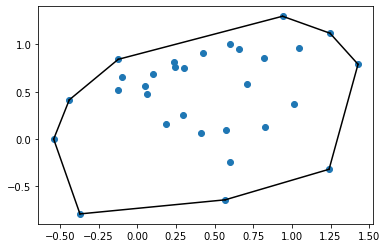

In [3]:
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex,1],'k-')

### Points on simplex
- For points on simplex, there exist a cutting plane to seperate rest of data
- we can initialize the cutting plane with normal direction
- Search over all conbination of points for the best place to find form the cutting polygon

In [4]:
vertices = np.unique(hull.simplices.flatten())

In [5]:
# Need a adjacency list
adj_list = {}
for i in vertices:
    adj_list[i] = []
    for simplex in hull.simplices:
        index, = np.where(simplex==i)
        if index.size > 0:
            adj_list[i].append(simplex[0] if index[0]==1 else simplex[1])
    adj_list[i].sort()

In [6]:
def construct_A_matrix(points, vertices, pivot_index):
    A = np.zeros((len(vertices)-1, 2))
    cur = 0
    for vertex in vertices:
        if vertex != pivot_index:
            A[cur] = points[vertex] - points[pivot_index]
            cur += 1
    return A


def sumOfSquaredDistance(params,points, pivot_point):
    dist = 0
    for point in points:
        d = (params.dot(point)-params.dot(pivot_point))/np.linalg.norm(params)
        dist += d**2
    return dist

In [7]:
def plot_solution(points, combination, params, x_range = [-10,10]):
    # Each line a(x-x0) + b(y-y0) = 0
    # y = -a/b(x-x0)+y0
    for i,vertex in enumerate(combination):
        if params[i*2+1] == 0:
            x = np.array([points[vertex,0]]*50)
            y = np.linspace(2*x_range[0], 2*x_range[1])
        else:
            x = np.linspace(x_range[0], x_range[1])
            y = -params[i*2] / params[i*2+1] * (x - points[vertex,0]) + points[vertex,1]
        plt.plot(x,y,label=f"vertex: {points[vertex]} {vertex}")
    plt.plot(points[:,0], points[:,1], 'o')
    plt.xlim(-2,2)
    plt.ylim(-2,2)
    plt.legend()
        

In [8]:
# Setup the optimization problem
# Assume select 5 points out of x points

combs = combinations(vertices, 5)
optimial_value = np.inf
solutions = []
for comb in combs:
    prog = mp.MathematicalProgram()
    # For each combination setup and solve an optimization problem
    # First define the constraints
    constraints = []
    As = []
    x = prog.NewContinuousVariables(2 * 5)
    for i,vetx in enumerate(comb):
        A = construct_A_matrix(points, vertices, vetx)
        As.append(A)
        lb=np.asarray([0.01] * len(A)) # Avoid getting trivial solution
        ub=np.asarray([np.inf] * len(A))
        #constraints.append(prog.AddConstraint(lambda z: A@z, lb=lb, ub=ub, vars = x[i*2:(i+1)*2]))
        constraints.append(prog.AddLinearConstraint(A=A,lb=lb,ub=ub, vars=x[i*2:(i+1)*2]))
        #prog.AddCost(lambda z: (z-1).dot(z-1), vars = [x[i*2],x[i*2+1]])
        
        # Define the cost as sum of squared distance between all vertices to the plane
        func = partial(sumOfSquaredDistance, points=points[vertices], pivot_point=points[vetx])
        prog.AddCost(func, vars=x[i*2:(i+1)*2])
        
        

    # Start solving the program
    x_init = np.random.uniform(-2,2,10)
    solver = SnoptSolver()
    #result = solver.Solve(prog, x_init)
    result = mp.Solve(prog)
    solution = result.GetSolution()
    # Define some criteria for evaluation
    solutions.append((solution,comb))
    # Check solution's feasibility
    for i,constraint in enumerate(constraints):
        assert(constraint.evaluator().CheckSatisfied(solution[i*2:(i+1)*2], tol=1e-5))


In [9]:
# Solve for intersection, first we need to sort the order of comb based on graph
def sortSolution(solution, comb, vertices):
    visited = [comb[0]]
    sorted_comb = [comb[0]]
    sorted_solution = np.zeros_like(solution)
    sorted_solution[:2] = solution[:2]
    current_vert = comb[0]
    for i in range(len(vertices)-1):
        next_verts = adj_list[current_vert]
        if next_verts[0] in visited:
            current_vert = next_verts[1]
        else:
            current_vert = next_verts[0]
        visited.append(current_vert)
        if current_vert in comb:
            sorted_comb.append(current_vert)
            cur = len(sorted_comb)
            index = np.where(comb==current_vert)[0][0]
            sorted_solution[(cur-1)*2:cur*2] = solution[index*2:(index+1)*2]
    return sorted_solution, sorted_comb    

In [10]:
def polyArea(intersecs):
    x = intersecs[:,0]
    y = intersecs[:,1]
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))
# Problem becomes how to set proper objectives
# We hope each intersection to be as far away from each other as adjacent one possible

minArea = np.inf
bestIntersecs = None
best_sorted_solution = None
best_sorted_comb = None
for solution in solutions:
    sorted_solution, sorted_comb = sortSolution(solution[0], solution[1], vertices)
    # Solve intersection between two lines
    intersecs = []
    valid = True
    for i in range(len(sorted_comb)):
        param1 = sorted_solution[i*2:(i+1)*2]/np.linalg.norm(sorted_solution[i*2:(i+1)*2])
        j = (i+1)%5
        param2 = sorted_solution[j*2:(j+1)*2]/np.linalg.norm(sorted_solution[j*2:(j+1)*2])
        det = param1[0]*param2[1] - param1[1] * param2[0]
        if abs(det) < 1e-4: # Bad solution co-linear
            valid = False
            break
        x_intersec = 1/det * np.array([param2[1], -param2[1]]).dot(np.array([points[sorted_comb[i]].dot(param1),points[sorted_comb[j]].dot(param2)]))
        y_intersec = 1/det * np.array([-param2[0], param2[0]]).dot(np.array([points[sorted_comb[i]].dot(param1),points[sorted_comb[j]].dot(param2)]))
        intersecs.append(np.array([x_intersec, y_intersec]))
    if valid and len(ConvexHull(np.asarray(intersecs)).simplices) == len(intersecs): # Only proper intersect can result in convex polygon
        # Calculate the area of the polygon
        intersecs = np.asarray(intersecs)
        area = polyArea(intersecs)
        if area < minArea:
            minArea = area
            bestIntersecs = intersecs
            best_sorted_solution = sorted_solution
            best_sorted_comb = sorted_comb
        


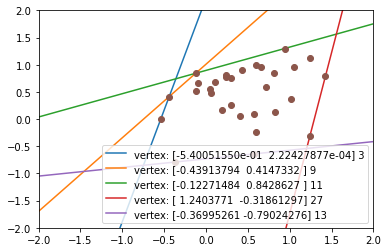

In [11]:
plot_solution(points, best_sorted_comb, best_sorted_solution)